In [1]:
import sys

path='/home/tomas/Ulmer-Berechnung/alps2qutipplus-april/alps2qutipplus-main/'

sys.path.insert(1, path) 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qutip
import scipy.linalg as linalg
import time
from multiprocessing import Pool
from itertools import product
from typing import Optional

import alpsqutip.parallelized_functions_and_workers as plME

from alpsqutip import (build_system, list_models_in_alps_xml,
                       list_geometries_in_alps_xml, graph_from_alps_xml,
                       model_from_alps_xml,
                       restricted_maxent_toolkit as me)

from alpsqutip.operators.states.utils import safe_exp_and_normalize ## function used to safely and robustly map K-states to states

from alpsqutip.scalarprod import fetch_covar_scalar_product
from alpsqutip.operators.states.gibbs import GibbsDensityOperator, GibbsProductDensityOperator

In [4]:

from alpsqutip.operators.arithmetic import (
    ScalarOperator,
    LocalOperator,
    OneBodyOperator,
    Operator,
    ProductOperator,
    ScalarOperator,
    SumOperator,
    QutipOperator
)

from alpsqutip.operators.simplify import simplify_sum_operator
from alpsqutip.optimized_projections import opt_project_to_n_body_operator
from alpsqutip.operators.states.meanfield.projections import project_to_n_body_operator

In [5]:
params={}

params['size']=7
params['Jx']=1.25; params['Jy'] = 0.8*params['Jx']; params['Jz']=0.*params['Jx']

from scipy.optimize import root, fsolve
Ffactor=np.real(max(np.roots(np.poly1d([1, 0, -(params['Jx']*params['Jy']+params['Jx']*params['Jy']+params['Jy']*params['Jz']), 
                           -2*params['Jx']*params['Jy']*params['Jz']]))))
chi_y=fsolve(lambda x,y: x*np.arcsinh(x)-np.sqrt(x**2+1)-y, 1e-1, args=(0))[0]
vLR=4*Ffactor*chi_y


In [6]:
from itertools import combinations
from functools import reduce

# Build system
system = build_system(geometry_name="open chain lattice", model_name="spin", 
                      L=params['size'], J=1)

sites = [s for s in system.sites]
sx_ops = [system.site_operator("Sx", f'1[{i}]') for i in range(len(sites))]
sy_ops = [system.site_operator("Sy", f'1[{i}]') for i in range(len(sites))]
sz_ops = [system.site_operator("Sz", f'1[{i}]') for i in range(len(sites))]

# Optional: full identity operator
idop = reduce(Operator.__mul__, [system.site_operator('identity@1[' + str(i) + ']') for i in range(len(sites))])

# XYZ nearest-neighbor Hamiltonian
H_XYZ = 0
for i in range(len(sites) - 1):  # Only nearest-neighbors
    H_XYZ += (
        params['Jx'] * sx_ops[i] * sx_ops[i+1] +
        params['Jy'] * sy_ops[i] * sy_ops[i+1] +
        params['Jz'] * sz_ops[i] * sz_ops[i+1]
    )

H_XYZ = H_XYZ.simplify()
H = H_XYZ

loading model spin  over graph open chain lattice


In [7]:
HBB0=[idop, system.site_operator('Sx', '1[0]'), system.site_operator('Sy', '1[0]'), system.site_operator('Sz', '1[0]')]

phi0 = np.array([.0, .25, .25, 10.])
K0 = phi0@HBB0
sigma0 = GibbsProductDensityOperator(K0)
phi0[0] = np.log(sigma0.tr())
K0 = phi0@HBB0
sigma0 = GibbsProductDensityOperator(K0)
[(sigma0 * op).tr() for op in sz_ops] 

[(-0.49964270571677594+0j), 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [28]:
obs_SzA=sum(sz for sz in sz_ops)

timespan=np.linspace(.0, 70.1/vLR,100)

In [29]:
evs_obs_ex=qutip.mesolve(H=H.to_qutip(), rho0=sigma0.to_qutip()
                         , tlist=timespan, e_ops=[obs_SzA.to_qutip()])

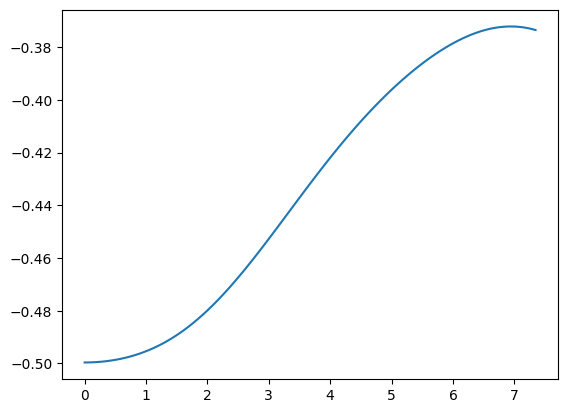

In [30]:
plt.plot(timespan, evs_obs_ex.expect[0])

sp_local_non_act=me.fetch_covar_scalar_product(sigma=sigma0) ## choosing of the scalar product
HBB_ell_non_act=plME.parallelized_real_time_projection_of_hierarchical_basis(
    generator=H,
    seed_op=K0+1e-10*H,
    sigma_ref=sigma0,
    nmax=chosen_depth,
    deep=m0,
    num_workers=num_workers
)

Gram_matrix_non_act = plME.parallel_gram_matrix_fine(basis = HBB_ell_non_act, 
                                                       sp = sp_local_non_act,
                                                       num_workers=num_workers)
R_non_act = np.linalg.cholesky(Gram_matrix_non_act).conj().T

b_orth= linalg.inv(R_non_act.T) @ HBB_ell_non_act

Hij_tensor_non_act_non_orth = plME.compute_Hij_tensor_non_orth(
    basis = HBB_ell_non_act, 
    generator = H, 
    sp = sp_local_non_act,
    sigma_ref = sigma0,
    nmax = chosen_depth,
    Gram = Gram_matrix_non_act,
            num_workers=num_workers
)

Hij_tensor_non_act = (linalg.inv(R_non_act).T 
                  @ Hij_tensor_non_act_non_orth 
                  @ linalg.inv(R_non_act)) ### In this convention for R_act, the orthonormal Hij_orth is
                                           ### Hij_orth = (R**-1).T @ Hij_non_orth @ (R**-1)
    
phi0_proj_non_act = np.array([sp_local_non_act(K0, op) for op in b_orth])
new_obs_local=sum(phi0a * opa for phi0a, opa in zip(phi0_proj_non_act, b_orth)).simplify()
print("Fita: Check", ((new_obs_local.to_qutip() - K0.to_qutip())).norm())

phi_at_timet = np.array([
    (linalg.expm(Hij_tensor_non_act*(t-.0)) @ phi0_proj_non_act) for t in timespan
])

K_at_timet = [(phit @ b_orth).simplify() for phit in phi_at_timet]
sigma_at_timet = [GibbsDensityOperator(Kt).tidyup() for Kt in K_at_timet]
evs_non_act = [(sigmat.to_qutip().ptrace(ptrace_list) * obs_SzA.to_qutip().ptrace(ptrace_list)).tr()
               for sigmat in sigma_at_timet]

In [31]:
simulations={}

In [24]:

tgt_obs = obs_SzA
sp_local = fetch_covar_scalar_product(sigma0)

from scipy.linalg import cho_solve, cho_factor
       
simulations[1] = {
    "parms":{
    "chosen_depth": 6,
    "m0": 2,
    "ell_prime": None,
    "eps": 1e-4,
    },
  "saved_cut_times_index_ell":[0],
   "no_acts_ell" : [0],
    "local_bound_error_ell":[],
    "spectral_norm_Hij_tensor_ell":[],
    "instantaneous_w_errors":[],
} 

current_simulation = simulations[1]
current_simulation_parms = current_simulation["parms"]
chosen_depth = current_simulation_parms["chosen_depth"]
eps_tol = current_simulation_parms["eps"]
m0 = current_simulation_parms["m0"]
ell_prime=current_simulation_parms["ell_prime"]
num_workers=2

In [25]:
print("a. start t=", list(timespan).index(0))
start = time.time()
local_bound_error_ell = []
simulations[1]["evs"] = [(sigma0* tgt_obs).tr()]  # initial observable expectation
sp_local = fetch_covar_scalar_product(sigma=sigma0)
sigma_act = sigma0
local_t_value = 0.0

# Initial bass construction and orthogonalization
HBB_ell_act = plME.parallelized_real_time_projection_of_hierarchical_basis(
    generator=H,
    seed_op=K0+1e-10*H,
    sigma_ref=sigma_act,
    nmax=m0,
    deep=chosen_depth,
    ell_prime=ell_prime,
    num_workers=num_workers
)

HBB_ell_act = [op.tidyup(1e-7) for op in HBB_ell_act ]
print(f"b. HBB_ell_act, {time.time() - start:.6f}s"); start = time.time()

Gram_matrix_act = plME.parallel_gram_matrix_fine(basis = HBB_ell_act, 
                                           sp = sp_local,
                                           num_workers=num_workers)

R_act = np.linalg.cholesky(Gram_matrix_act).conj().T

b_orth= linalg.inv(R_act.T) @ HBB_ell_act
print(f"c. orth basis act, {time.time() - start:.6f}s"); start = time.time()

Hij_tensor_act_non_orth = plME.compute_Hij_tensor_non_orth(
    basis = HBB_ell_act, 
    generator = H, 
    sp = sp_local,
    sigma_ref = sigma0,
    nmax=2,
    Gram = Gram_matrix_act,
    num_workers=num_workers
)

Hij_tensor_act = (linalg.inv(R_act).T 
                  @ Hij_tensor_act_non_orth 
                  @ linalg.inv(R_act)) ### In this convention for R_act, the orthonormal Hij_orth is
                                       ### Hij_orth = (R**-1).T @ Hij_non_orth @ (R**-1)

phi0_proj_act = np.array([sp_local(K0, op) for op in b_orth])
new_obs_local=sum(phi0a * opa for phi0a, opa in zip(phi0_proj_act, b_orth)).simplify().tidyup(1e-7)
print("Fita: Check", ((new_obs_local.to_qutip() - K0.to_qutip())).norm())
print(f"d. Hij-tensor-act, {time.time() - start:.6f}s"); start = time.time()

for t in timespan[1:]:
    start = time.time()
    
    delta_t = t - local_t_value
    exp_H = linalg.expm(delta_t * Hij_tensor_act)
    phi_local = np.real(exp_H @ phi0_proj_act)
    
    print(f"A. phi-local {time.time() - start:.2f}s");    start = time.time()
    
    K_local = (phi_local @ b_orth).simplify().tidyup(1e-7)
    #b_orth=None; HBB_ell_act = None
    
    print(f"B. obs-local {time.time() - start:.2f}s");    start = time.time()
        
    simulations[1]["evs"].append((GibbsDensityOperator(K_local)*tgt_obs).tr()) ### the minus is here
    
    print(f"C. Ev {time.time() - start:.2f}s");    start = time.time()
    
    # Compute the local bound error ratio
    numerator = me.m_th_partial_sum(phi=phi_local, m=2)
    denominator = me.m_th_partial_sum(phi=phi_local, m=0)
    local_bound_error_ell.append(numerator / denominator)
    
    # Check if error is above threshold, trigger basis update
    if abs(local_bound_error_ell[-1]) >= eps_tol:
        local_t_value = t
        print(f"a. Renormalization at t={list(timespan).index(t)}")
        
        print("a. start t=", list(timespan).index(t))
        if False:
            K_act=plME.general_worker(("projection",(K_local + 1e-10*H,
                                                     1, sigma_act)))
            sigma_act=GibbsProductDensityOperator(K_act)
            sp_local = fetch_covar_scalar_product(sigma_act)
        
        start = time.time()
        HBB_ell_act = plME.parallelized_real_time_projection_of_hierarchical_basis(
                generator=H,
                seed_op=K_local,
                sigma_ref=sigma_act,
                nmax=m0,
                deep=chosen_depth,
                ell_prime=None,
                num_workers=num_workers
        )
        print(f"b. HBB_ell_act, {time.time() - start:.6f}s")
        
        start = time.time()
        
        Gram_matrix_act = plME.parallel_gram_matrix_fine(basis = HBB_ell_act, 
                                           sp = sp_local,
                                           num_workers=num_workers)
        
        R_act = np.linalg.cholesky(Gram_matrix_act).conj().T

        b_orth= linalg.inv(R_act.T) @ HBB_ell_act

        print(f"c. orth basis act, {time.time() - start:.6f}s")
        
        start = time.time()
        
        Hij_tensor_act_non_orth = plME.compute_Hij_tensor_non_orth(
            basis = HBB_ell_act, 
            generator = H, 
            sp = sp_local,
            sigma_ref = sigma_act,
            nmax=m0,
            Gram = Gram_matrix_act,
            num_workers=num_workers+1)
            
        print(f"d. Hij-tensor-act, {time.time() - start:.6f}s")
        Hij_tensor_act = linalg.inv(R_act).T @ Hij_tensor_act_non_orth @ linalg.inv(R_act)
        phi0_proj_act = np.array([sp_local(K_local, op) for op in b_orth])
        new_obs_local=sum(phi0a * opa for phi0a, opa in zip(phi0_proj_act, b_orth)).simplify()
        print("Fita: Check", ((K_local.to_qutip() - new_obs_local.to_qutip())).norm())
    else:
        # If error below tolerance, keep current basis and coefficients
        pass

a. start t= 0
b. HBB_ell_act, 24.458993s
c. orth basis act, 11.994923s
Fita: Check 1.137978058668449e-13
d. Hij-tensor-act, 3.857924s
A. phi-local 0.01s
B. obs-local 0.02s
C. Ev 0.16s
A. phi-local 0.00s
B. obs-local 0.01s
C. Ev 0.18s
A. phi-local 0.01s
B. obs-local 0.02s
C. Ev 0.15s
A. phi-local 0.00s
B. obs-local 0.02s
C. Ev 0.16s
A. phi-local 0.00s
B. obs-local 0.03s
C. Ev 0.15s
A. phi-local 0.00s
B. obs-local 0.01s
C. Ev 0.20s
A. phi-local 0.00s
B. obs-local 0.01s
C. Ev 0.15s
A. phi-local 0.00s
B. obs-local 0.01s
C. Ev 0.18s
A. phi-local 0.00s
B. obs-local 0.02s
C. Ev 0.16s
a. Renormalization at t=9
a. start t= 9
b. HBB_ell_act, 57.084291s
c. orth basis act, 22.180083s
d. Hij-tensor-act, 5.368131s
Fita: Check 1.0399776436803228e-12
A. phi-local 0.01s
B. obs-local 0.03s
C. Ev 0.15s
A. phi-local 0.00s
B. obs-local 0.02s
C. Ev 0.16s
A. phi-local 0.01s
B. obs-local 0.03s
C. Ev 0.13s
A. phi-local 0.00s
B. obs-local 0.03s
C. Ev 0.15s
A. phi-local 0.01s
B. obs-local 0.04s
C. Ev 0.13s
A. ph

B. obs-local 0.05s
C. Ev 0.14s
A. phi-local 0.00s
B. obs-local 0.02s
C. Ev 0.17s
A. phi-local 0.00s
B. obs-local 0.04s
C. Ev 0.14s
A. phi-local 0.00s
B. obs-local 0.06s
C. Ev 0.14s
A. phi-local 0.00s
B. obs-local 0.05s
C. Ev 0.12s
A. phi-local 0.00s
B. obs-local 0.05s
C. Ev 0.13s
a. Renormalization at t=126
a. start t= 126
b. HBB_ell_act, 59.462891s
c. orth basis act, 27.204233s
d. Hij-tensor-act, 6.419655s
Fita: Check 5.193486324066599e-13
A. phi-local 0.00s
B. obs-local 0.02s
C. Ev 0.18s
A. phi-local 0.00s
B. obs-local 0.03s
C. Ev 0.17s
A. phi-local 0.01s
B. obs-local 0.04s
C. Ev 0.15s
A. phi-local 0.00s
B. obs-local 0.02s
C. Ev 0.17s
A. phi-local 0.00s
B. obs-local 0.02s
C. Ev 0.13s
A. phi-local 0.00s
B. obs-local 0.02s
C. Ev 0.16s
A. phi-local 0.00s
B. obs-local 0.02s
C. Ev 0.15s
A. phi-local 0.00s
B. obs-local 0.02s
C. Ev 0.16s
A. phi-local 0.00s
B. obs-local 0.04s
C. Ev 0.15s
a. Renormalization at t=135
a. start t= 135
b. HBB_ell_act, 60.179720s
c. orth basis act, 26.776881s
d. H

In [34]:
tgt_obs = obs_SzA
sp_local = fetch_covar_scalar_product(sigma0)

from scipy.linalg import cho_solve, cho_factor
       
simulations[2] = {
    "parms":{
    "chosen_depth": 6,
    "m0": 3,
    "ell_prime": None,
    "eps": 1e-4,
    },
  "saved_cut_times_index_ell":[0],
   "no_acts_ell" : [0],
    "local_bound_error_ell":[],
    "spectral_norm_Hij_tensor_ell":[],
    "instantaneous_w_errors":[],
} 

current_simulation = simulations[2]
current_simulation_parms = current_simulation["parms"]
chosen_depth = current_simulation_parms["chosen_depth"]
eps_tol = current_simulation_parms["eps"]
m0 = current_simulation_parms["m0"]
ell_prime=current_simulation_parms["ell_prime"]
num_workers=3

In [35]:
print("a. start t=", list(timespan).index(0))
start = time.time()
local_bound_error_ell = []
simulations[2]["evs"] = [(sigma0* tgt_obs).tr()]  # initial observable expectation
sp_local = fetch_covar_scalar_product(sigma=sigma0)
sigma_act = sigma0
local_t_value = 0.0

# Initial bass construction and orthogonalization
HBB_ell_act = plME.parallelized_real_time_projection_of_hierarchical_basis(
    generator=H,
    seed_op=K0+1e-10*H,
    sigma_ref=sigma_act,
    nmax=m0,
    deep=chosen_depth,
    ell_prime=ell_prime,
    num_workers=num_workers
)

HBB_ell_act = [op.tidyup(1e-7) for op in HBB_ell_act ]
print(f"b. HBB_ell_act, {time.time() - start:.6f}s"); start = time.time()

Gram_matrix_act = plME.parallel_gram_matrix_fine(basis = HBB_ell_act, 
                                           sp = sp_local,
                                           num_workers=num_workers)

R_act = np.linalg.cholesky(Gram_matrix_act).conj().T

b_orth= linalg.inv(R_act.T) @ HBB_ell_act
print(f"c. orth basis act, {time.time() - start:.6f}s"); start = time.time()

Hij_tensor_act_non_orth = plME.compute_Hij_tensor_non_orth(
    basis = HBB_ell_act, 
    generator = H, 
    sp = sp_local,
    sigma_ref = sigma0,
    nmax=2,
    Gram = Gram_matrix_act,
    num_workers=num_workers
)

Hij_tensor_act = (linalg.inv(R_act).T 
                  @ Hij_tensor_act_non_orth 
                  @ linalg.inv(R_act)) ### In this convention for R_act, the orthonormal Hij_orth is
                                       ### Hij_orth = (R**-1).T @ Hij_non_orth @ (R**-1)

phi0_proj_act = np.array([sp_local(K0, op) for op in b_orth])
new_obs_local=sum(phi0a * opa for phi0a, opa in zip(phi0_proj_act, b_orth)).simplify().tidyup(1e-7)
print("Fita: Check", ((new_obs_local.to_qutip() - K0.to_qutip())).norm())
print(f"d. Hij-tensor-act, {time.time() - start:.6f}s"); start = time.time()

for t in timespan[1:]:
    start = time.time()
    
    delta_t = t - local_t_value
    exp_H = linalg.expm(delta_t * Hij_tensor_act)
    phi_local = np.real(exp_H @ phi0_proj_act)
    
    print(f"A. phi-local {time.time() - start:.2f}s");    start = time.time()
    
    K_local = (phi_local @ b_orth).simplify().tidyup(1e-7)
    #b_orth=None; HBB_ell_act = None
    
    print(f"B. obs-local {time.time() - start:.2f}s");    start = time.time()
        
    simulations[2]["evs"].append((GibbsDensityOperator(K_local)*tgt_obs).tr()) ### the minus is here
    
    print(f"C. Ev {time.time() - start:.2f}s");    start = time.time()
    
    # Compute the local bound error ratio
    numerator = me.m_th_partial_sum(phi=phi_local, m=2)
    denominator = me.m_th_partial_sum(phi=phi_local, m=0)
    local_bound_error_ell.append(numerator / denominator)
    
    # Check if error is above threshold, trigger basis update
    if abs(local_bound_error_ell[-1]) >= eps_tol:
        local_t_value = t
        print(f"a. Renormalization at t={list(timespan).index(t)}")
        
        print("a. start t=", list(timespan).index(t))
        if False:
            K_act=plME.general_worker(("projection",(K_local + 1e-10*H,
                                                     1, sigma_act)))
            sigma_act=GibbsProductDensityOperator(K_act)
            sp_local = fetch_covar_scalar_product(sigma_act)
        
        start = time.time()
        HBB_ell_act = plME.parallelized_real_time_projection_of_hierarchical_basis(
                generator=H,
                seed_op=K_local,
                sigma_ref=sigma_act,
                nmax=m0,
                deep=chosen_depth,
                ell_prime=None,
                num_workers=num_workers
        )
        print(f"b. HBB_ell_act, {time.time() - start:.6f}s")
        
        start = time.time()
        
        Gram_matrix_act = plME.parallel_gram_matrix_fine(basis = HBB_ell_act, 
                                           sp = sp_local,
                                           num_workers=num_workers)
        
        R_act = np.linalg.cholesky(Gram_matrix_act).conj().T

        b_orth= linalg.inv(R_act.T) @ HBB_ell_act

        print(f"c. orth basis act, {time.time() - start:.6f}s")
        
        start = time.time()
        
        Hij_tensor_act_non_orth = plME.compute_Hij_tensor_non_orth(
            basis = HBB_ell_act, 
            generator = H, 
            sp = sp_local,
            sigma_ref = sigma_act,
            nmax=m0,
            Gram = Gram_matrix_act,
            num_workers=num_workers)
            
        print(f"d. Hij-tensor-act, {time.time() - start:.6f}s")
        Hij_tensor_act = linalg.inv(R_act).T @ Hij_tensor_act_non_orth @ linalg.inv(R_act)
        phi0_proj_act = np.array([sp_local(K_local, op) for op in b_orth])
        new_obs_local=sum(phi0a * opa for phi0a, opa in zip(phi0_proj_act, b_orth)).simplify()
        print("Fita: Check", ((K_local.to_qutip() - new_obs_local.to_qutip())).norm())
    else:
        # If error below tolerance, keep current basis and coefficients
        pass

a. start t= 0
b. HBB_ell_act, 40.226925s
c. orth basis act, 13.005390s
Fita: Check 1.137978058668449e-13
d. Hij-tensor-act, 3.824584s
A. phi-local 0.00s
B. obs-local 0.01s
C. Ev 0.18s
A. phi-local 0.01s
B. obs-local 0.02s
C. Ev 0.15s
A. phi-local 0.00s
B. obs-local 0.02s
C. Ev 0.14s
A. phi-local 0.00s
B. obs-local 0.02s
C. Ev 0.15s
A. phi-local 0.00s
B. obs-local 0.02s
C. Ev 0.13s
A. phi-local 0.00s
B. obs-local 0.01s
C. Ev 0.16s
A. phi-local 0.00s
B. obs-local 0.01s
C. Ev 0.16s
A. phi-local 0.00s
B. obs-local 0.01s
C. Ev 0.46s
A. phi-local 0.00s
B. obs-local 0.01s
C. Ev 0.04s
A. phi-local 0.00s
B. obs-local 0.01s
C. Ev 0.16s
A. phi-local 0.00s
B. obs-local 0.02s
C. Ev 0.16s
a. Renormalization at t=11
a. start t= 11
b. HBB_ell_act, 78.476680s
c. orth basis act, 33.753607s
d. Hij-tensor-act, 9.621824s
Fita: Check 3.11148245049467e-13
A. phi-local 0.00s
B. obs-local 0.03s
C. Ev 0.16s
A. phi-local 0.00s
B. obs-local 0.07s
C. Ev 0.12s
A. phi-local 0.00s
B. obs-local 0.10s
C. Ev 0.09s
A. ph

In [37]:
 simulations[1]["evs"][:m]

KeyError: 1

IndexError: index 100 is out of bounds for axis 0 with size 100

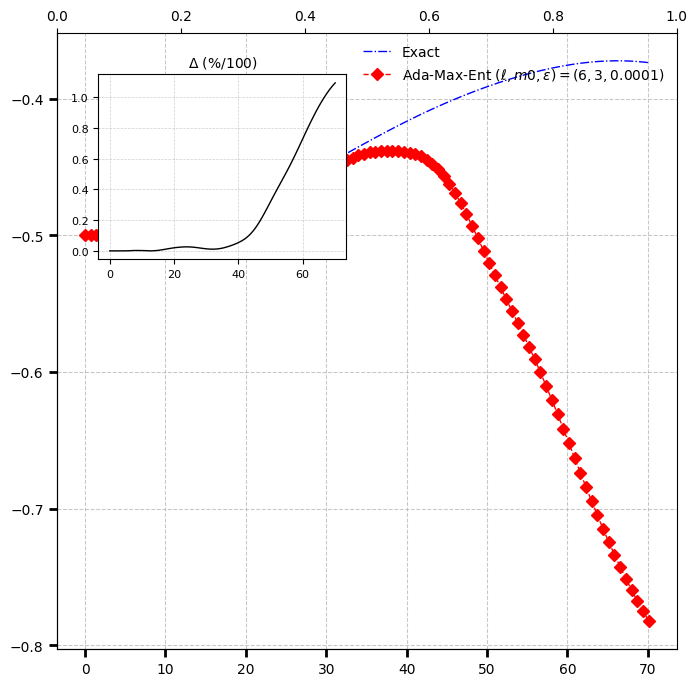

In [39]:
# import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Création de la figure et des axes principaux
fig, ax = plt.subplots(figsize=(8, 8))

n =1
m =100


# --- Courbe principale: observable exact + simulation ---
ax.plot(timespan[:m]*vLR, evs_obs_ex.expect[0][:m],
        label='Exact', color="blue", linestyle='dashdot', linewidth=1)

l = simulations[2]["parms"]["chosen_depth"]
m0 = simulations[2]["parms"]["m0"]
ell_prime = simulations[2]["parms"]["ell_prime"]
eps = simulations[2]["parms"]["eps"]

label_sim2 = fr'Ada-Max-Ent $(\ell, m0, \epsilon) = ({l}, {m0}, {eps})$'

ax.plot(timespan[:m]*vLR, simulations[2]["evs"][:m],
        label=label_sim2, color='red', linestyle='--', marker='D', linewidth=1)


# --- Inset: Delta courbe ---
weigthed_fidelity = np.array([abs(evs_obs_ex.expect[0][i] - simulations[2]["evs"][i])/abs(evs_obs_ex.expect[0][i])
                             for i in range(0, m)])
inset_ax = inset_axes(ax, width="40%", height="30%", loc='upper left', borderpad=3)
inset_ax.plot(timespan[:m]*vLR,weigthed_fidelity,
              color="black", linestyle='solid', linewidth=1)
inset_ax.set_title(r'$\Delta\ (\%/100)$', fontsize=10)

inset_ax.tick_params(labelsize=8)
inset_ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

# --- Style global ---
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(direction='out', length=6, width=2, which='major', grid_alpha=0.6)
ax.grid(True, which='major', linestyle='--', linewidth=0.75, alpha=0.7)
ax.legend(frameon=False, loc='upper right')

# Axe secondaire en haut
ax1 = ax.twiny()
ax1.set_xlim(timespan[0], timespan[m])
ax.set_xlabel(r'$t v_{\rm LR} \, [L]$')
ax1.set_xlabel(r'$t \, [{\rm arb. units}]$')

# Titre
plt.title(r'non-local Hamiltonian, $L={}$, $J_x={}$, $v_{{\rm LR}}={}$'.format(
    params['size'], 
    round(params['Jx'], 3), 
    round(vLR, 3)
))

plt.tight_layout()


In [43]:
timespan[m]

IndexError: index 100 is out of bounds for axis 0 with size 100

In [128]:
def flatten_to_product_terms(op):
    """Recursively extract all ProductOperator terms from a nested SumOperator."""
    if hasattr(op, "as_sum_of_products"):
        sop = op.as_sum_of_products()
        if hasattr(sop, "terms"):
            return [term for subop in sop.terms for term in flatten_to_product_terms(subop)]
    return [op]  # base case: it's already a ProductOperator


all_terms = [term for op in HBB_ell_act for term in flatten_to_product_terms(op)]
len(all_terms)

249

In [129]:
def orthogonalize_operators(ops, sp, *, tol=1e-12):
    """
    Parameters
    ----------
    ops : list
        List of (possibly) non‑orthogonal operator objects.
    sp  : callable
        Scalar‑product function   sp(A, B)  ->  complex.
        E.g.  sp = fetch_covar_scalar_product(Gibbs(idop))
    tol : float
        Eigenvalue cutoff below which directions are discarded.
    Returns
    -------
    list
        Orthonormal operators with respect to `sp`.
    """
    n = len(ops)

    # 1) Gram matrix  G_ij = ⟨i|j⟩
    G = np.empty((n, n), dtype=np.complex128)
    for i in range(n):
        for j in range(i, n):
            G[i, j] = sp(ops[i], ops[j])
            G[j, i] = np.conjugate(G[i, j])

    # 2) Eigendecompose  G = U Λ U†
    eigval, U = np.linalg.eigh(G)

    # 3) Throw away (nearly) null directions
    keep = eigval > tol
    if not np.any(keep):
        raise RuntimeError("Input set is (numerically) linearly dependent.")
    Λm12 = np.diag(1.0 / np.sqrt(eigval[keep]))   # Λ^{-1/2}

    # 4) Coefficient matrix  C = U_keep Λ^{-1/2}
    C = U[:, keep] @ Λm12           # shape (n, n_keep)

    # 5) Build orthonormalised operators
    orth_ops = []
    for k in range(C.shape[1]):
        op_k = sum(C[i, k] * ops[i] for i in range(n))
        orth_ops.append(op_k)       # already normalised by construction
    return orth_ops

In [133]:
from itertools import combinations

L = len(sites)                     # number of spins

# ---------- 0‑body (identity) ----------
basis_up_to_2 = [idop]

# ---------- 1‑body ----------
one_body_ops = sx_ops + sy_ops + sz_ops       # 3 L operators
basis_up_to_2.extend(one_body_ops)

# ---------- 2‑body ----------
two_body_ops = []
for i, j in combinations(range(L), 2):       # unordered pairs i < j
    two_body_ops.extend([
        sx_ops[i] * sx_ops[j],  sx_ops[i] * sy_ops[j],  sx_ops[i] * sz_ops[j],
        sy_ops[i] * sx_ops[j],  sy_ops[i] * sy_ops[j],  sy_ops[i] * sz_ops[j],
        sz_ops[i] * sx_ops[j],  sz_ops[i] * sy_ops[j],  sz_ops[i] * sz_ops[j],
    ])

# Optional: tidy/simplify each product as your library allows
# two_body_ops = [op.simplify() for op in two_body_ops]

basis_up_to_2.extend(two_body_ops)

print(f"Size of basis (≤2‑body): {len(basis_up_to_2)}")  # ⇒ 1 + 3 L + 9·(L choose 2)


Size of basis (≤2‑body): 211


In [136]:
sp=fetch_covar_scalar_product(GibbsProductDensityOperator(idop))

In [134]:
orth_ops = orthogonalize_operators(basis_up_to_2, fetch_covar_scalar_product(GibbsProductDensityOperator(idop)))

In [141]:
import numpy as np
from concurrent.futures import ProcessPoolExecutor
from functools import partial

# --- Define a wrapper that computes one row of Hij tensor ---
def compute_Hij_row(op2, H, orth_ops_serialized, sp):
    """Compute one row of the Hij tensor."""
    comm = plME.commutator_worker((H, op2))
    return [sp(op1, comm) for op1 in orth_ops_serialized]

# --- Use multiprocessing to compute rows in parallel ---
def parallel_Hij_tensor(orth_ops, H, sp, max_workers=None):
    # Serialize orth_ops once to avoid shared memory issues
    orth_ops_serialized = orth_ops  # if picklable already, else flatten or string-ify

    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(compute_Hij_row, op2, H, orth_ops_serialized, sp)
            for op2 in orth_ops
        ]
        results = [f.result() for f in futures]
    
    return np.array(results)

Hij_tensor_full = parallel_Hij_tensor(orth_ops, H, sp, max_workers=6)


In [147]:
phi0_proj_non_act = np.array([sp(K0, op) for op in orth_ops]) 
new_obs_local=sum(phi0a * opa for phi0a, opa in zip(phi0_proj_non_act, orth_ops)).simplify() 
print("Fita: Check", ((new_obs_local.to_qutip() - K0.to_qutip())).norm())

phi_at_timet = np.array([ (linalg.expm(Hij_tensor_full*(t-.0)) @ phi0_proj_non_act) for t in timespan ])

K_at_timet = [(phit @ orth_ops).simplify() for phit in phi_at_timet] 
sigma_at_timet = [GibbsDensityOperator(Kt).tidyup() for Kt in K_at_timet] 
evs_non_act = [(sigmat*tgt_obs).tr() for sigmat in sigma_at_timet]

Fita: Check 0.0


ArpackNoConvergence: ARPACK error -1: No convergence (100001 iterations, 1/3 eigenvectors converged)

In [159]:
evs_non_act = [(sigmat.to_qutip()*tgt_obs.to_qutip()).tr() for sigmat in sigma_at_timet[:10]]

ArpackNoConvergence: ARPACK error -1: No convergence (100001 iterations, 0/3 eigenvectors converged) [ARPACK error -14: ZNAUPD did not find any eigenvalues to sufficient accuracy.]

In [191]:
evs = []
obs = tgt_obs.to_qutip()

for i in range(len(timespan)):
    try:
        rho = sigma_at_timet[i].to_qutip()
        trace_val = np.real((rho * obs).tr())
        evs.append(trace_val)
    except Exception as e:
        # Optional: print or log the error
        # print(f"Skipped index {i}: {e}")
        continue


KeyboardInterrupt: 

In [196]:
(sigma_at_timet[59].to_qutip()*obs).tr()

(-4.251556070088691-6.1236155216612234e-18j)

In [188]:
obs

Quantum object: dims=[[2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2]], shape=(128, 128), type='oper', dtype=CSR, isherm=True
Qobj data =
[[-3.5  0.   0.  ...  0.   0.   0. ]
 [ 0.  -2.5  0.  ...  0.   0.   0. ]
 [ 0.   0.  -2.5 ...  0.   0.   0. ]
 ...
 [ 0.   0.   0.  ...  2.5  0.   0. ]
 [ 0.   0.   0.  ...  0.   2.5  0. ]
 [ 0.   0.   0.  ...  0.   0.   3.5]]

In [198]:
evs_obs_ex.expect[0][59]

-0.37591771347953873

In [173]:
evs_obs_ex

<Result
  Solver: mesolve
  Solver stats:
    method: 'scipy zvode adams'
    init time: 0.000156402587890625
    preparation time: 0.0014469623565673828
    run time: 0.40705013275146484
    solver: 'Master Equation Evolution'
    num_collapse: 0
  Time interval: [0.0, 15.728819214283591] (150 steps)
  Number of e_ops: 1
  State not saved.
>

/tmp/ipykernel_36390/4125036468.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


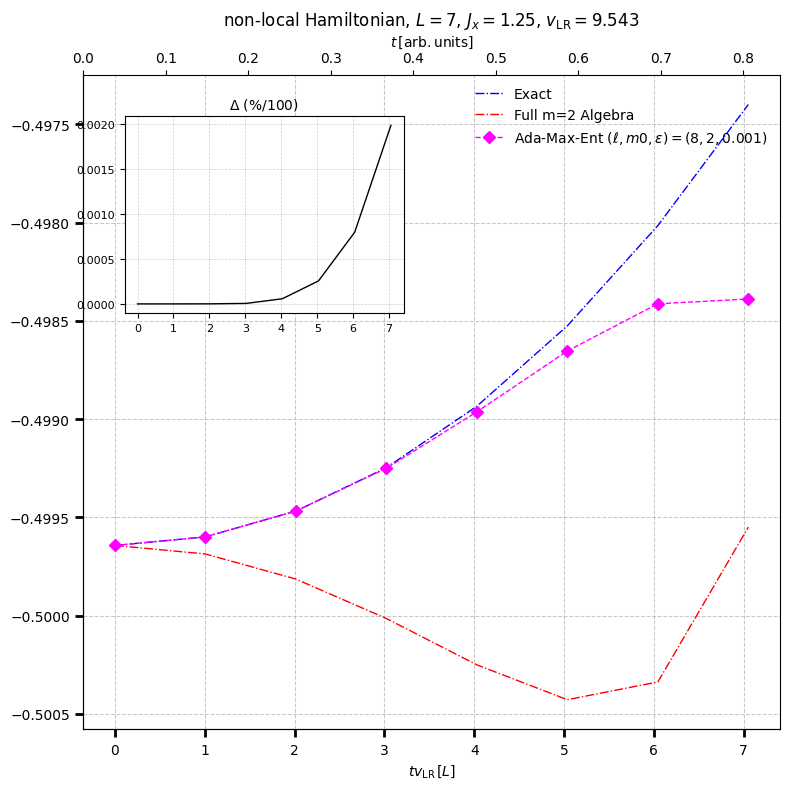

In [177]:
# import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Création de la figure et des axes principaux
fig, ax = plt.subplots(figsize=(8, 8))

n = 1
m = 8


# --- Courbe principale: observable exact + simulation ---
ax.plot(timespan[:m]*vLR, evs_obs_ex.expect[0][:m],
        label='Exact', color="blue", linestyle='dashdot', linewidth=1)


ax.plot(timespan[:m]*vLR, evs[:m],
        label='Full m=2 Algebra', color="red", linestyle='dashdot', linewidth=1)

l = simulations[1]["parms"]["chosen_depth"]
m0 = simulations[1]["parms"]["m0"]
ell_prime = simulations[1]["parms"]["ell_prime"]
eps = simulations[1]["parms"]["eps"]

label_sim1 = fr'Ada-Max-Ent $(\ell, m0, \epsilon) = ({l}, {m0}, {eps})$'

ax.plot(timespan[:m]*vLR, simulations[1]["evs"][:m],
        label=label_sim1, color='magenta', linestyle='--', marker='D', linewidth=1)

# --- Inset: Delta courbe ---
weigthed_fidelity = np.array([abs(evs_obs_ex.expect[0][i] - simulations[1]["evs"][i])/abs(evs_obs_ex.expect[0][i])
                             for i in range(0, m)])
inset_ax = inset_axes(ax, width="40%", height="30%", loc='upper left', borderpad=3)
inset_ax.plot(timespan[:m]*vLR,weigthed_fidelity,
              color="black", linestyle='solid', linewidth=1)
inset_ax.set_title(r'$\Delta\ (\%/100)$', fontsize=10)

inset_ax.tick_params(labelsize=8)
inset_ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

# --- Style global ---
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(direction='out', length=6, width=2, which='major', grid_alpha=0.6)
ax.grid(True, which='major', linestyle='--', linewidth=0.75, alpha=0.7)
ax.legend(frameon=False, loc='upper right')

# Axe secondaire en haut
ax1 = ax.twiny()
ax1.set_xlim(timespan[0], timespan[m])
ax.set_xlabel(r'$t v_{\rm LR} \, [L]$')
ax1.set_xlabel(r'$t \, [{\rm arb. units}]$')

# Titre
plt.title(r'non-local Hamiltonian, $L={}$, $J_x={}$, $v_{{\rm LR}}={}$'.format(
    params['size'], 
    round(params['Jx'], 3), 
    round(vLR, 3)
))

plt.tight_layout()


In [98]:
len(HBB_ell_act[3].terms)

27

In [21]:
(0.116-0.110)/0.110

0.05454545454545459

In [37]:
H*H

(
qutip interface operator for 1 x  
Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 0.0728125  0.         0.         0.0328125]
 [ 0.         0.2603125 -0.2296875  0.       ]
 [ 0.        -0.2296875  0.2603125  0.       ]
 [ 0.0328125  0.         0.         0.0728125]]
  +qutip interface operator for 1 x  
Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=CSR, isherm=False
Qobj data =
[[ 0.06890625  0.          0.          0.01640625  0.          0.02734375
  -0.01640625  0.        ]
 [ 0.         -0.06890625  0.11484375  0.          0.00390625  0.
   0.          0.01640625]
 [ 0.         -0.11484375  0.06890625  0.          0.11484375  0.
   0.          0.02734375]
 [-0.01640625  0.          0.         -0.06890625  0.         -0.11484375
   0.19140625  0.        ]
 [ 0.          0.19140625 -0.11484375  0.         -0.06890625  0.
   0.         -0.01640625]
 [ 0.02734375  0.          0.          0.11484